## This is the Jupyter Notebook for Computer Vision CA

> Import basic dependencies

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from typing import Tuple
import time

> **Question 1**

> A

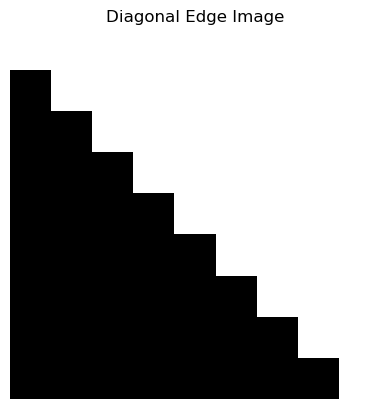

In [120]:
def create_diagonal_edge_image(size: int = 9) -> np.ndarray:
    """
    Generates a grayscale image with a diagonal edge from top-left to bottom-right.
    """
    img = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i < j or i == j:
                img[i, j] = 255  
    return img


diagonal_edge_image = create_diagonal_edge_image()
plt.imshow(diagonal_edge_image, cmap='gray')
plt.title('Diagonal Edge Image')
plt.axis('off')
plt.show()

>B

In [121]:
def compute_custom_gradient(img: np.ndarray, x:int, y:int) -> Tuple[float,float]:
    """
    Computes the gradient magnitude and direction at (x, y) using finite differences.
    Returns:
        magnitude: float
        direction: float in degrees
    """
    sobelX = np.array([
                        [-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]
                    ])
    sobelY = np.array([
                        [1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]
                    ])

    surrounding_pixels = img[y-1:y+2, x-1:x+2]
    Gx = 1/8 * np.sum(sobelX * surrounding_pixels)
    Gy = 1/8 * np.sum(sobelY * surrounding_pixels)

    magnitude = np.sqrt(Gx**2 + Gy**2)
    direction = np.arctan2(Gy, Gx) * (180.0 / np.pi)


    return float(magnitude), float(direction)

#Usage
x, y = 4, 4
magnitude, direction = compute_custom_gradient(diagonal_edge_image, x, y)
print(f"Gradient Magnitude at ({x}, {y}): {magnitude}")
print(f"Gradient Direction at ({x}, {y}): {direction} degrees")

Gradient Magnitude at (4, 4): 135.23417190192723
Gradient Direction at (4, 4): 45.0 degrees


> C

>**The directional bias of the Sobel operator can be improved using a 5x5 kernel**

In [122]:
def compute_diagonal_corrected_gradient(img: np.ndarray, x: int, y: int) -> Tuple[float, float]:
    """
    Modified gradient computation that handles diagonal edges more accurately.
    """
    sobelX = np.array([
                        [-1,-2,0,2,1],
                        [-1,-2,0,2,1],
                        [-2,-4,0,4,2],
                        [-1,-2,0,2,1],
                        [-1,-2,0,2,1]])

    sobelY = np.array([
                        [1,1,2,1,1],
                        [2,2,4,2,2],
                        [0,0,0,0,0],
                        [-2,-2,-4,-2,-2],
                        [-1,-1,-2,-1,-1]
                    ])


    surrounding_pixels = img[y-2:y+3, x-2:x+3]
    Gx = 1/18 * np.sum(sobelX * surrounding_pixels)
    Gy = 1/18 * np.sum(sobelY * surrounding_pixels)

    magnitude = np.sqrt(Gx**2 + Gy**2)
    direction = np.arctan2(Gy, Gx) * (180.0 / np.pi)

    return float(magnitude), float(direction)

#Usage
x, y = 4, 4
magnitude_custom, direction_custom = compute_custom_gradient(diagonal_edge_image, x, y)
magnitude_corrected, direction_corrected = compute_diagonal_corrected_gradient(diagonal_edge_image, x, y)
print(f"Custom Gradient Magnitude at ({x}, {y}): {magnitude_custom}")
print(f"Custom Gradient Direction at ({x}, {y}): {direction_custom} degrees")
print(f"Corrected Gradient Magnitude at ({x}, {y}): {magnitude_corrected}")
print(f"Corrected Gradient Direction at ({x}, {y}): {direction_corrected} degrees")


Custom Gradient Magnitude at (4, 4): 135.23417190192723
Custom Gradient Direction at (4, 4): 45.0 degrees
Corrected Gradient Magnitude at (4, 4): 220.38161346980726
Corrected Gradient Direction at (4, 4): 45.0 degrees


The 5x5 kernel is better than the standard 3x3 sobel kernel. This is seen in the Gradient Magnitude being measured at 220.38, which is much closer to the true flat edge value of 255 than 135.23.

>D

Strictly horizontal or vertical filters are only good at calculating the edges along a singular axis. However, a diagonal edge utilises two axises at the same time like a jagged staircase, meaning a partially correct calculation in both axises are utilised in both directions. The physical distance between the centers of diagonal pixels is slightly larger, because of
$\sqrt{x^2 + y^2} $ where x is horizontal pixel length, and y is the vertical pixel length. This leads to an underestimation of the true gradient magnitude from the naive horizontal/vertical filters.

My method improves the estimation of the magnitude of the gradient as it incorporates more information from surrounding pixels, allowing a more accurate average to be gathered from the calculations. For example, the standard 3x3 Sobel operator has a magnitude of 135.23, and the corrected function has a gradient of 220.38. The corrected function's difference from the true intensity value of 255 is much smaller than that of the 3x3 function. This 5x5 kernel utilises 25 pixels compared to 9 pixels, the weighting is more accurate with context from a greater amount of surrounding pixels.

>**Question 2**

Feature vector length: 192


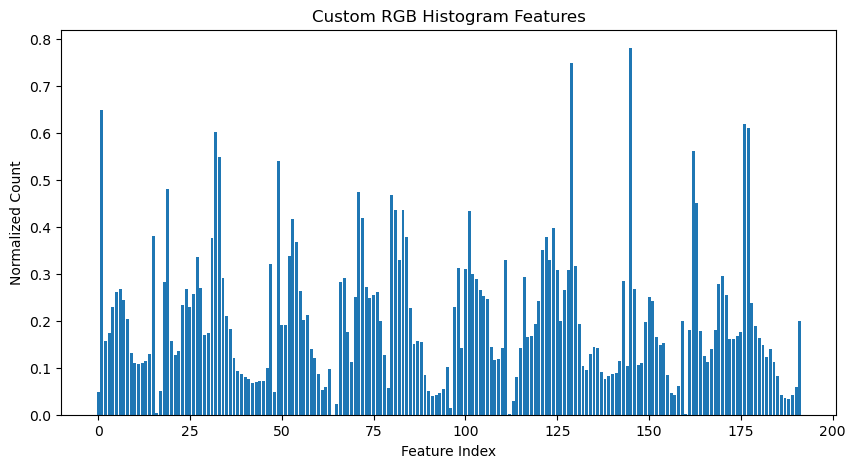

In [123]:
def custom_rgb_histogram(img: str, grid_blocks: int = 4, bins: int = 16) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes a custom RGB histogram for an image, dividing it into grid blocks and calculating histograms for each block.
    Args:
        img: Path to the input image.
        grid_blocks: Number of blocks to divide the image into (e.g., 4 for a 4x4 grid).
        bins: Number of bins for the histogram (e.g., 16 for 16 bins per channel).
    Returns:
        A feature vector containing the concatenated histograms for all blocks and channels.
    """
    img = cv2.imread(img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, _ = img_rgb.shape
    block_h = height // grid_blocks
    block_w = width // grid_blocks
    
    features = []
    for row in range(grid_blocks):
        for column in range(grid_blocks):
                y_start, y_end = row * block_h, (row + 1) * block_h
                x_start, x_end = column * block_w, (column + 1) * block_w
                cell = img_rgb[y_start:y_end, x_start:x_end]

                for channel in range(3):  # R, G, B channels
                    hist, _ = np.histogram(
                        cell[:, :, channel],
                        bins=bins,
                        range=(0, 256)
                    )
                    
                    hist = hist.astype(np.float32)
                    cv2.normalize(hist,hist)
                    features.extend(hist)
                    
    return np.array(features)

histogram = custom_rgb_histogram("data/flower.jpg")

features = custom_rgb_histogram("data/flower.jpg", grid_blocks=2, bins=16)
print(f"Feature vector length: {len(features)}")

plt.figure(figsize=(10, 5))
plt.bar(range(len(features)), features)
plt.title('Custom RGB Histogram Features')
plt.xlabel('Feature Index')
plt.ylabel('Normalized Count')
plt.show()


- The distribution of colours in the image is retained, as well as a rough spatial layout. This from how the histrogram maps the spatial layout of the colours in the image.

- The shape and edge structure in the image are lost as the algorithm does not keep that information to be mapped onto the histogram

- This modified representation would be advantageous in Content-Based Image Retrieval, as it would be able to distinguish between images with the similar colours, but different spatial structures within the image.

>**Question 3**

In [124]:
img_array = cv2.imread("data/flower.jpg")
img_array_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

bin_value = 16

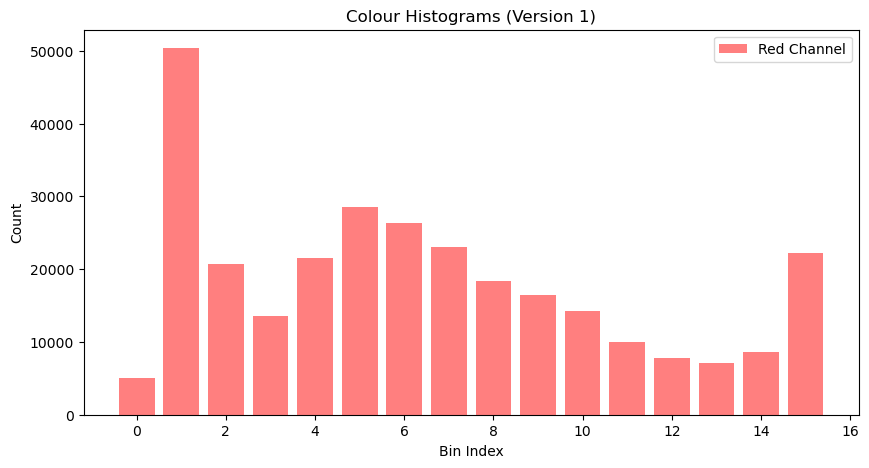

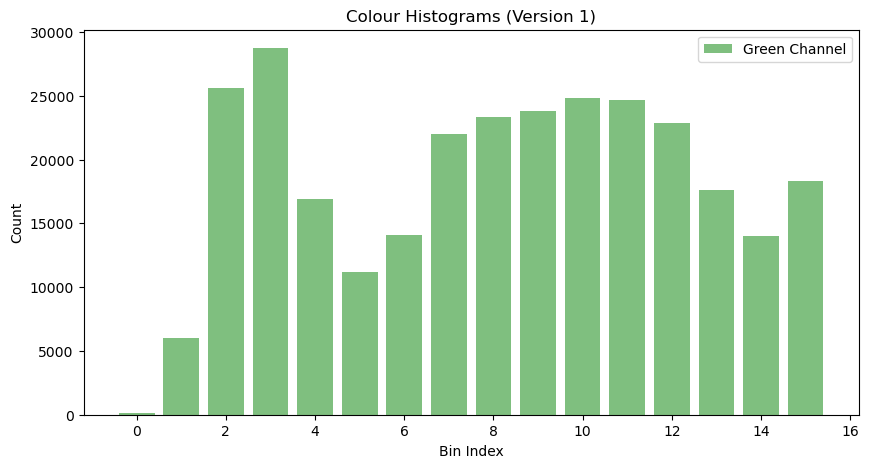

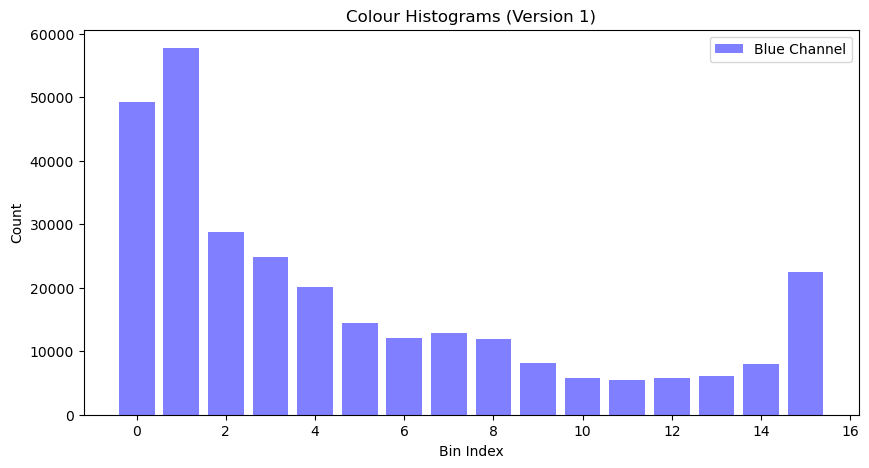

In [130]:
def compute_colour_histogram_v1(im, num_bins):
    """
    Vectorised NumPy implementation
    No Python loops
    Returns:
        hist_r: np.ndarray
        hist_g: np.ndarray
        hist_b: np.ndarray
    """

    red_channel = im[:, :, 0].ravel()
    green_channel = im[:, :, 1].ravel()
    blue_channel = im[:, :, 2].ravel()

    hist_r, _ = np.histogram(red_channel, bins=num_bins, range=(0, 256))
    hist_g, _ = np.histogram(green_channel, bins=num_bins, range=(0, 256))
    hist_b, _ = np.histogram(blue_channel, bins=num_bins, range=(0, 256))   

    return hist_r, hist_g, hist_b

hist_red, hist_green, hist_blue = compute_colour_histogram_v1(img_array_rgb, num_bins=16)

channels = [(hist_red, 'red', 'Red'), (hist_green, 'green', 'Green'), (hist_blue, 'blue', 'Blue')]

for hist, color, name in channels:
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(hist)), hist, color=color, alpha=0.5, label=f'{name} Channel')
    plt.title('Colour Histograms (Version 1)')
    plt.xlabel('Bin Index')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

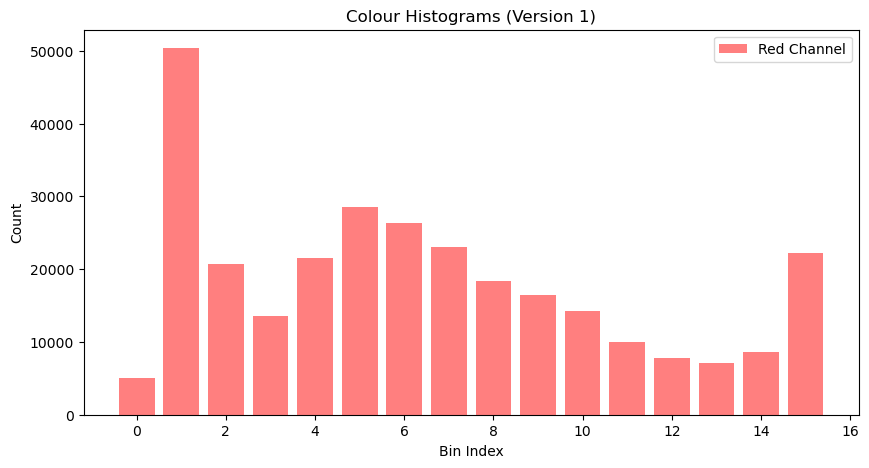

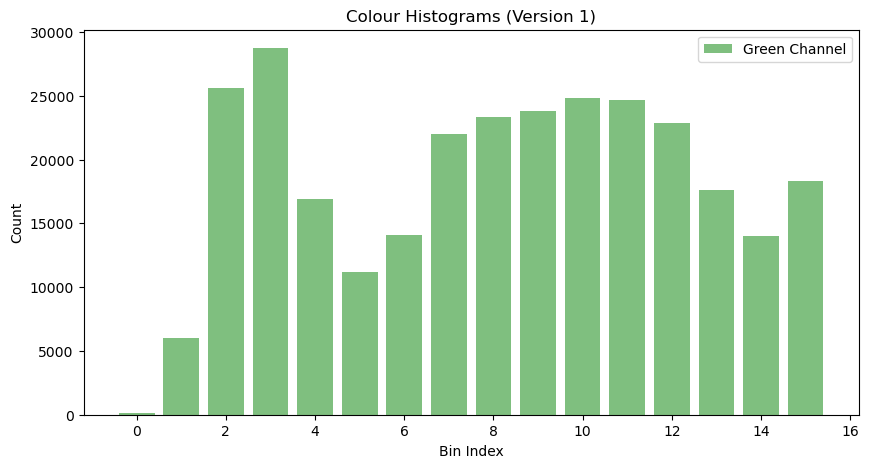

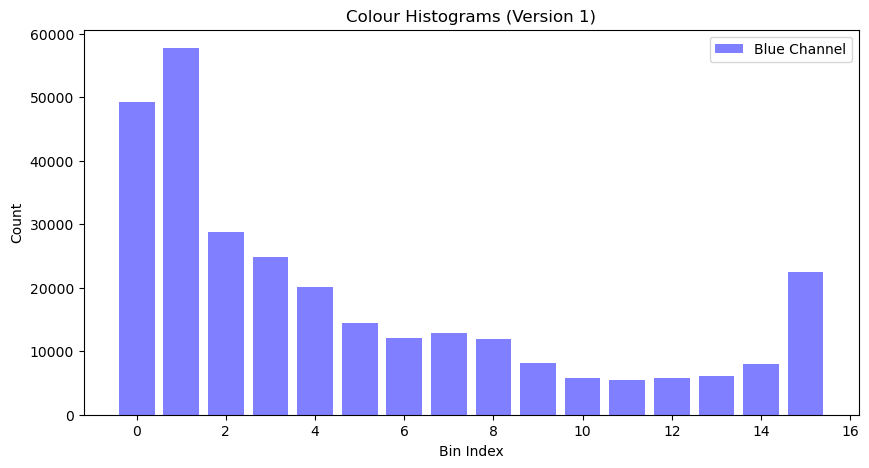

In [131]:
def compute_colour_histogram_v2(im, num_bins):
    """
    Compute RGB Histogram
    No numpy histogram functions
    Returns:
        hist_r: np.ndarray
        hist_g: np.ndarray
        hist_b: np.ndarray
    """
    height = len(im)
    width = len(im[0])

    hist_r = [0] * num_bins
    hist_g = [0] * num_bins
    hist_b = [0] * num_bins

    bin_width = 256 / num_bins

    for i in range(height):
        for j in range(width):
            r, g, b = im[i][j]

            r_bin = int(r / bin_width)
            g_bin = int(g / bin_width)
            b_bin = int(b / bin_width)

            hist_r[r_bin] += 1
            hist_g[g_bin] += 1
            hist_b[b_bin] += 1

    return hist_r, hist_g, hist_b

hist_red_v2, hist_green_v2, hist_blue_v2 = compute_colour_histogram_v2(img_array_rgb, num_bins=16)
channels = [(hist_red, 'red', 'Red'), (hist_green, 'green', 'Green'), (hist_blue, 'blue', 'Blue')]

for hist, color, name in channels:
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(hist)), hist, color=color, alpha=0.5, label=f'{name} Channel')
    plt.title('Colour Histograms (Version 1)')
    plt.xlabel('Bin Index')
    plt.ylabel('Count')
    plt.legend()
    plt.show()


In [132]:

start_time_v1 = time.time()
compute_colour_histogram_v1(img_array_rgb, bin_value)
end_time_v1 = time.time()
print(f"Time taken for compute_colour_histogram_v1: {end_time_v1 - start_time_v1:.4f} seconds")

start_time_v2 = time.time()
compute_colour_histogram_v2(img_array_rgb, bin_value)
end_time_v2 = time.time()
print(f"Time taken for compute_colour_histogram_v2: {end_time_v2 - start_time_v2:.4f} seconds")



Time taken for compute_colour_histogram_v1: 0.0211 seconds
Time taken for compute_colour_histogram_v2: 2.1914 seconds


- The pure python implementation takes approximately 100 times longer despite the same number of bins and img_array input used.
- Computational Tradeoffs
    - NumPy is written in C, which compiles directly to machine code, which can be executed immediately. This makes the implementation a lot faster, as Python uses an interpreter and interprets to bytecode which is then executed using a virtual machine written in C. 
    - NumPy uses faster vectorised operations, compared to the slower naive implementation of loops. The vectorisation means that there is only one data type while the python loops store dynamically typed data. It also means that the data is stored in a continuous block of memory, compared to the variety of memory addresses used for a nested loop. However, this does mean that every item in the array must be the same type.
- Memory Tradeoffs
    - As mentioned previously, NumPy uses a continuous memory block, which means that the memory allocated will be the same as the image size. Higher resolution images, or even larger images would cause memory issues. This does lead to a better performance if the image can be stored, as it is stored in the cache.
    - On the other hand, since Python iterates through the list with the memory allocated is only for the bin it is currently on in the loop. This makes the Python implementation much more memory efficient but the constant fetching from memory addresses causes a much slower execution speed. 

- Modern systems often have enough memory to store larger images, so the NumPy implementation is often preferred to the less efficient Python implementation.
    

>**Question 4**

In [ ]:
def compute_inverse_transform(points, theta, t):
    """
    Given a set of 2D points, with a centroid, consider a transform H that rotates around the centroid by an angle theta.
    Afterwards, it applies a translation by a vector t. This function computes the inverse of this transform H and applies it to the given points.
    Arguments:
    points: np.ndarray of shape (N, 2) representing the 2D points.
    theta: float, the angle of rotation in radians.
    t: np.ndarray of shape (2,) representing the translation vector.
    Returns:
    np.ndarray of shape (N, 2) representing the transformed points.
    """
    if len(points) == 0:
        print("Point array is empty.")

    centroid = np.mean(points, axis=0)

    cos_theta = np.cos(-theta)
    sin_theta = np.sin(-theta)
    rotation_matrix = np.array([
                                [cos_theta,-sin_theta],
                                [sin_theta,cos_theta]
                            ])

    shifted_points = points - centroid

    rotated_points = np.dot(shifted_points, rotation_matrix.T)

    original_points = rotated_points + centroid - t

    return original_points


